In [652]:
import pandas as pd
from pandasql import sqldf
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

In [653]:
conn = ###

In [625]:
def query(sql_query):
    table = pd.read_sql_query(sql_query, con = conn)
    return table

In [34]:
query('SELECT MAX(item_total) FROM orders')

,max
0,480746


## Retention по когортам ( за все месяцы) 

In [70]:
query('''
SELECT user_id, DATE_TRUNC('month',created_at) as order_month
FROM orders 
GROUP BY user_id,DATE_TRUNC('month',created_at)
LIMIT 10
''')

,user_id,order_month
0,31,2018-01-01
1,31,2018-02-01
2,31,2018-03-01
3,31,2018-04-01
4,31,2018-05-01
5,31,2018-06-01
6,31,2018-07-01
7,31,2018-08-01
8,31,2018-09-01
9,31,2018-10-01


In [71]:
## Первый месяц первого заказа для каждого user_id

query('''
SELECT user_id, MIN(DATE_TRUNC('month',created_at)) AS first_month
FROM orders
GROUP BY user_id
''')

,user_id,first_month
0,279693,2019-03-01
1,223071,2019-01-01
2,95503,2019-03-01
3,167276,2018-12-01
4,71653,2018-01-01
...,...,...
119026,135006,2018-08-01
119027,158829,2018-09-01
119028,128842,2018-07-01
119029,635398,2019-07-01


## Получаем  таблицу retention-а

Рассчитывается количество покупок уникального пользователя в месяц t до $t_n$ ( по сути rolling retention)

In [641]:
retention = query('''


Select  month_number,
count(distinct case when month_number IN (1,2,3,4,5,6,7,8,9,10,11,12) and month_first = 1 then user_id ELSE NULL end) as m1,
COUNT(DISTINCT CASE WHEN month_number IN (2,3,4,5,6,7,8,9,10,11,12) and month_first = 2  then user_id ELSE NULL end) as m2,
count(distinct case when month_number IN (3,4,5,6,7,8,9,10,11,12) and month_first = 3 then user_id ELSE NULL end) as m3,
count(distinct case when month_number IN (4,5,6,7,8,9,10,11,12) and month_first = 4 then user_id ELSE NULL end) as m4,
count(distinct case when month_number IN (5,6,7,8,9,10,11,12) and month_first = 5 then user_id ELSE NULL end) as m5,
count(distinct case when month_number IN (6,7,8,9,10,11,12) and month_first = 6 then user_id ELSE NULL end) as m6,
count(distinct case when month_number IN (7,8,9,10,11,12) and month_first = 7 then user_id ELSE NULL end) as m7,
count(distinct case when month_number IN (8,9,10,11,12) and month_first = 8 then user_id ELSE NULL end) as m8,
count(distinct case when month_number IN (9,10,11,12) and month_first = 9 then user_id ELSE NULL end) as m9,
count(distinct case when month_number IN (10,11,12) and month_first = 10 then user_id ELSE NULL end) as m10,
count(distinct case when month_number IN (11,12) and month_first = 11 then user_id ELSE NULL end) as m11,
count(distinct case when month_number IN (12) and month_first = 12 then user_id ELSE NULL end) as m12





FROM (
SELECT df1.user_id, EXTRACT(MONTH from df1.order_month) as month_number,  EXTRACT(MONTH from df2.first_month) as month_first
FROM (SELECT user_id, DATE_TRUNC('month',created_at) as order_month
FROM orders 
GROUP BY user_id,DATE_TRUNC('month',created_at)) AS df1 JOIN
(SELECT user_id, MIN(DATE_TRUNC('month',created_at)) AS first_month
FROM orders
GROUP BY user_id) AS df2 ON df1.user_id = df2.user_id ) AS x


GROUP BY month_number
ORDER BY month_number




''')

In [643]:
retention = retention.T

In [644]:
retention.columns = retention.loc['month_number']

In [645]:
retention.drop('month_number',inplace = True)

In [646]:
retention

month_number,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
m1,12384.0,3283.0,2934.0,2950.0,2729.0,2566.0,2461.0,1475.0,1335.0,1213.0,1149.0,935.0
m2,0.0,8896.0,1727.0,1525.0,1399.0,1390.0,1324.0,568.0,403.0,381.0,331.0,266.0
m3,0.0,0.0,8698.0,1898.0,1589.0,1446.0,1361.0,546.0,379.0,353.0,336.0,265.0
m4,0.0,0.0,0.0,11751.0,2570.0,2146.0,1921.0,698.0,502.0,454.0,383.0,305.0
m5,0.0,0.0,0.0,0.0,14046.0,3192.0,2615.0,967.0,677.0,602.0,516.0,368.0
m6,0.0,0.0,0.0,0.0,0.0,13538.0,3330.0,838.0,479.0,438.0,379.0,278.0
m7,0.0,0.0,0.0,0.0,0.0,0.0,15810.0,1090.0,549.0,459.0,387.0,287.0
m8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5844.0,732.0,570.0,428.0,314.0
m9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6846.0,1217.0,836.0,571.0
m10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7671.0,1278.0,839.0


In [647]:
for i in range(retention.shape[0]):
    maxi = retention.iloc[i].max()
    retention.iloc[i] = retention.iloc[i]/retention.iloc[i].max()*100
    
    

In [648]:
mask = (retention == 0)

## График retention

Text(0.5, 1.0, 'Cohort by month:percentage')

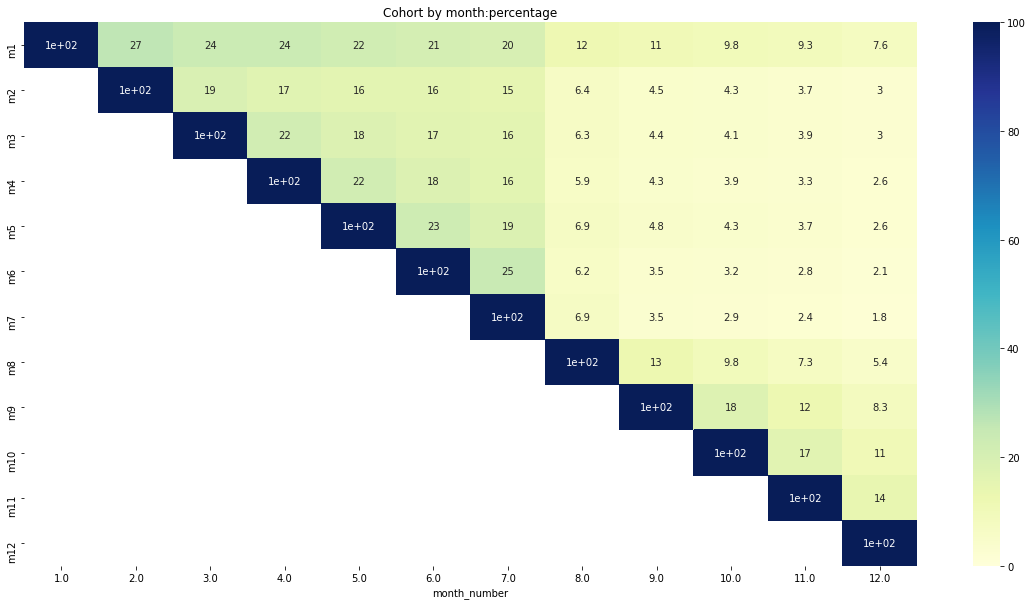

In [649]:
plt.figure(figsize = (20,10))
sns.heatmap(retention, annot = True, cmap='YlGnBu', mask  = mask )
plt.title('Cohort by month:percentage')

**Можно увидеть, что в первых когортах ( пользователи, которые совершили первый заказ с января по июнь) retention от 20% до 25%, 
а далее с июля идет уменьшения retention первого месяца. Интересно заметить, что также есть некоторая зеленая зона для первых 6-ти месяцев, где после присоединения июньских клиентов ретеншен всех когорт в месяцах, которые прошли падает  и становится меньше 15-20% для этих пользователей**

# RFM   - сегментирование

 Так как данные давние, предположим, что мы смотрим через месяц после последней даты, то есть 09 04 - чисто для сравнения, ни на какую истинность не претенедуя
 
 * Разделим допустим на 4 сегмента

In [361]:
query('''

SELECT  user_id, MAX(shipped_at) as last_order, 
'2019-09-04 00:00:00' - max(shipped_at) as diff_days,
COUNT(DISTINCT(id)) as all_orders,
count(distinct(extract(month from shipped_at))) as months,
COUNT(DISTINCT(id))/count(distinct(extract(month from shipped_at))) as orders_monthly,
sum(item_total + total_cost ) as total_revenue,
sum(item_total + total_cost ) / COUNT(DISTINCT(id)) as revenue_per_order
FROM orders
where state = 'shipped'
group by user_id
order by user_id
LIMIT 5
''')

,user_id,last_order,diff_days,all_orders,months,orders_monthly,total_revenue,revenue_per_order
0,31,2019-07-23 16:25:32,42 days 07:34:28,49,12,4,629436.0,12845.632653
1,45,2019-07-28 17:32:13,37 days 06:27:47,40,12,3,113009.0,2825.225000
2,60,2018-04-07 06:15:48,514 days 17:44:12,1,1,1,6843.0,6843.000000
3,63,2018-09-22 20:35:15,346 days 03:24:45,1,1,1,5464.0,5464.000000
4,97,2018-08-23 16:57:04,376 days 07:02:56,8,4,2,37517.0,4689.625000


In [658]:
RFM = query('''

SELECT  user_id, MAX(shipped_at) as last_order, 
'2019-09-04 00:00:00' - max(shipped_at) as diff_days,
COUNT(DISTINCT(id)) as all_orders,
count(distinct(extract(month from shipped_at))) as months,
COUNT(DISTINCT(id))/count(distinct(extract(month from shipped_at))) as orders_monthly,
sum(item_total + total_cost ) as total_revenue,
sum(item_total + total_cost ) / COUNT(DISTINCT(id)) as revenue_per_order
FROM orders
where state = 'shipped'
group by user_id
order by user_id


''')

**Границы групп - худшие группы по заказов, так как большинство все таки делают не более одного заказа поэтому разделим конкретно их на 3 группы**

In [474]:
query('''
select k, 
percentile_disc(k) within group( order by x.all_orders) as perc_all_orders,
percentile_disc(k) within group( order by x.diff_days) as perc_diff_days,
percentile_disc(k) within group( order by x.total_revenue) as perc_total_revenue

from (SELECT  user_id, MAX(shipped_at) as last_order, 
'2019-09-04 00:00:00' - max(shipped_at) as diff_days,
COUNT(DISTINCT(id)) as all_orders,
count(distinct(extract(month from shipped_at))) as months,
COUNT(DISTINCT(id))/count(distinct(extract(month from shipped_at))) as orders_monthly,
sum(item_total + total_cost ) as total_revenue,
sum(item_total + total_cost ) / COUNT(DISTINCT(id)) as revenue_per_order
FROM orders
where state = 'shipped'
group by user_id
order by user_id) as x, generate_series(0.33, 1, 0.33) as k
group by k
''')

,k,perc_all_orders,perc_diff_days,perc_total_revenue
0,0.33,1,90 days 03:57:22,3056.0
1,0.66,2,279 days 06:19:00,7561.0
2,0.99,27,586 days 13:15:53,159013.0


In [475]:

def group_assigment(x):
    percentiles = [3056,7561,159013] 
    if x <= percentiles[0]:
        return 1 
    elif x > percentiles[0] and x <= percentiles[1]:
        return 2
    elif x > percentiles[1] and x <= percentiles[2]:
        return 3
    elif x > percentiles[2]:
        return 4
        
    

In [659]:
RFM['Recency'] = RFM['diff_days'].dt.days.map(group_assigment)

RFM['Frequency'] = RFM['all_orders'].map(group_assigment)

RFM['Money'] = RFM['total_revenue'].map(group_assigment)

RFM['RFM_score'] = RFM['Recency']  + RFM['Frequency']  + RFM['Money']
RFM = RFM[['user_id', 'Recency','Frequency','Money','RFM_score']]

In [660]:
RFM

,user_id,Recency,Frequency,Money,RFM_score
0,31,1,1,4,6
1,45,1,1,3,5
2,60,1,1,2,4
3,63,1,1,2,4
4,97,1,1,3,5
...,...,...,...,...,...
119019,681550,1,1,3,5
119020,681627,1,1,2,4
119021,681806,1,1,2,4
119022,682248,1,1,2,4


**RFM метод позволяет разделить людей на категории по частоте их заказов, их давности и доходности.**

In [664]:
RFM['RFM_score'].value_counts().sort_values()

6     1190
5    39276
3    39278
4    39280
Name: RFM_score, dtype: int64

**Как  и ожидалось наименьшие группы с RFM-score 5,6 - самые доходные и частые клиенты, больше всего групп со скором 3,4 - то есть наименее доходные ( туда преимущественно попадают те, кто делают за все время всего  1 заказ).**

## Revenue и когорты пользователей

**Суть - делим пользователей по дате их первого заказа в группе, далее считаем средний чек для клиентов, далее считаем средний чек пользователей в этот месяц -> то есть пытаемся понять сколько тратят люди в когорте в следующие месяцы**

In [510]:
query('''
select df1.user_id, df1.month, df1.avg, df2.first_month
from 
(select user_id,extract(month from orders.shipped_at) as month, 
AVG(item_total + total_cost)
from orders
where state = 'shipped'
group by user_id, extract(month from orders.shipped_at)) as df1 join
(SELECT user_id, MIN(extract('month' from created_at)) AS first_month
FROM orders
GROUP BY user_id) as df2 on df1.user_id = df2.user_id

''')

,user_id,month,avg,first_month
0,31,1.0,9710.142857,1.0
1,31,2.0,8129.833333,1.0
2,31,3.0,12675.000000,1.0
3,31,4.0,14345.250000,1.0
4,31,5.0,12454.400000,1.0
...,...,...,...,...
221621,681257,8.0,3371.000000,8.0
221622,681464,8.0,2183.000000,8.0
221623,681550,8.0,9714.000000,8.0
221624,681627,8.0,4605.000000,8.0


In [543]:
query('''
select generate_series(m,12,1) as k, m  

from generate_series(1,12,1) as m
limit 24
''')

,k,m
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,1


In [665]:
mean_checks = query('''

select 
month,
AVG(case when (month = k and m = 1) and first_month = 1 then avg_price else null end) as m1, 
AVG(case when (month = k and m = 2) and first_month = 2 then avg_price else null end) as m2,
AVG(case when (month = k and m =3) and first_month = 3 then avg_price else null end) as m3,
AVG(case when (month = k and m = 4) and first_month = 4 then avg_price else null end) as m4,
AVG(case when (month = k and m = 5) and first_month = 5 then avg_price else null end) as m5,
AVG(case when (month = k and m = 6) and first_month = 6 then avg_price else null end) as m6,
AVG(case when (month = k and m = 7) and first_month = 7 then avg_price else null end) as m7,
AVG(case when (month = k and m = 8) and first_month = 8 then avg_price else null end) as m8,
AVG(case when (month = k and m = 9) and first_month = 9 then avg_price else null end) as m9,
AVG(case when (month = k and m = 10) and first_month = 10 then avg_price else null end) as m10,
AVG(case when (month = k and m = 11) and first_month = 11 then avg_price else null end) as m11,
AVG(case when (month = k and m = 12) and first_month = 12 then avg_price else null end) as m12

from (select df1.user_id, df1.month, df1.avg_price, df2.first_month
from 
(select user_id,extract(month from orders.shipped_at) as month, 
AVG(item_total + total_cost) as avg_price
from orders
where state = 'shipped'
group by user_id, extract(month from orders.shipped_at)) as df1 join
(SELECT user_id, MIN(extract('month' from created_at)) AS first_month
FROM orders
GROUP BY user_id) as df2 on df1.user_id = df2.user_id
) as x , (select generate_series(m,12,1) as k, m  
from generate_series(1,12,1) as m) as y

GROUP BY month
ORDER BY month


''')

**Здесь тоже считается все вертикально - то есть столбец m1 показывает все значения для пользователей, которые сделали первый заказ в первом месяцы, на дальнейшие месяцы**



In [666]:
mean_checks 

,month,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1.0,4505.871266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,5291.202029,4070.977087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,5432.425816,4740.779578,4037.046454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,5552.578947,5244.645661,4649.373198,4025.404843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,5620.811992,5217.423986,5052.883072,4773.821344,4091.537449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6.0,5635.740273,5388.906349,5128.191588,5192.667982,4825.157265,4220.798682,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,5850.799483,5683.432802,5591.738085,5403.960304,5635.575713,5342.508218,5267.694325,NaN,NaN,NaN,NaN,NaN
7,8.0,5463.006145,5263.138430,5045.821771,5215.823848,5126.438214,5235.823036,5304.248811,3956.540136,NaN,NaN,NaN,NaN
8,9.0,5358.166080,4952.693172,4746.809411,4750.220882,4631.903503,4779.045647,4439.662072,4440.629373,3849.292806,NaN,NaN,NaN
9,10.0,5574.791613,5076.531825,4908.388945,5120.389720,4764.025317,5011.386934,4822.170954,4728.135927,4705.986903,3963.450991,NaN,NaN


<AxesSubplot:>

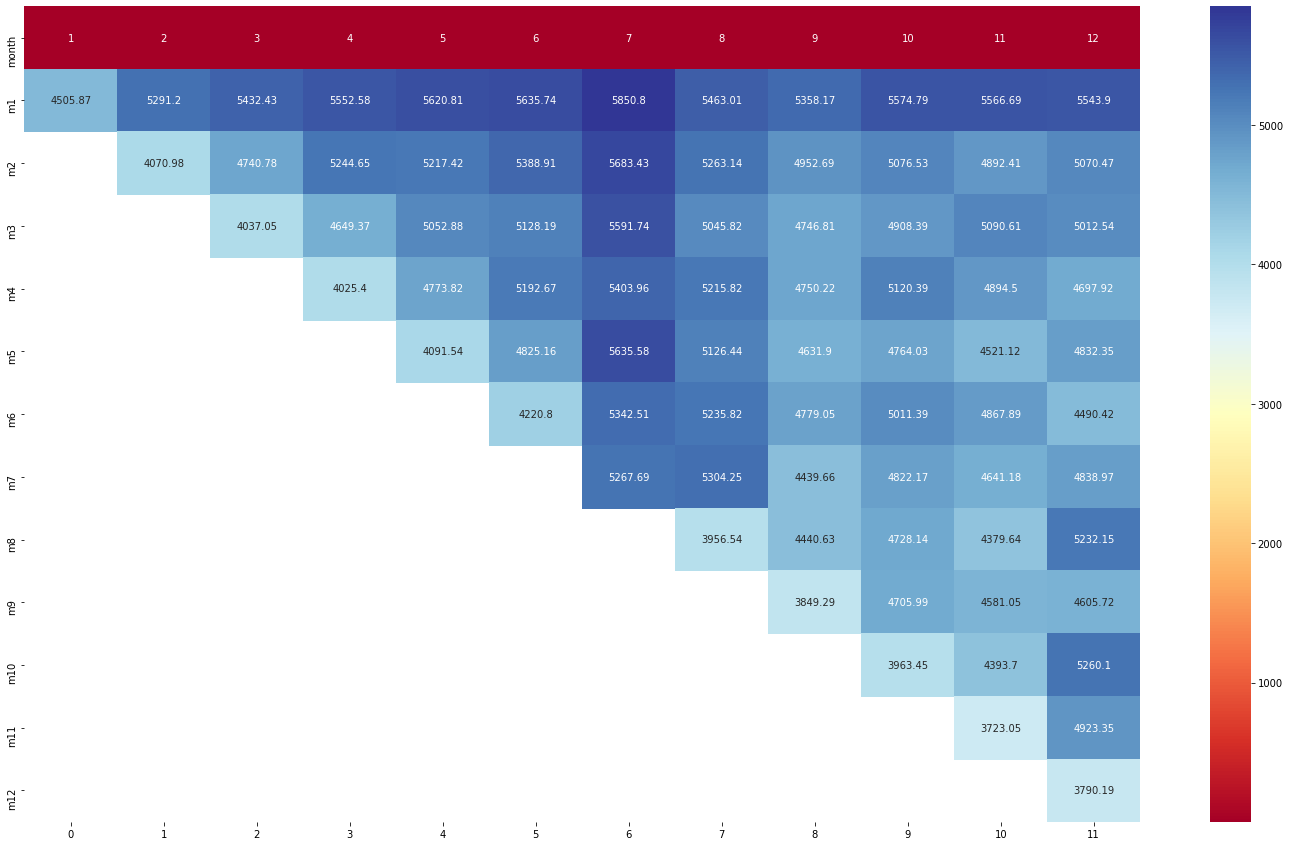

In [667]:
plt.figure(figsize = (25,15))
sns.heatmap(mean_checks.T, annot = True, cmap = 'RdYlBu', fmt='g',)

**Мы видим, что в большинстве когорт клиенты со временем начинают платить больше, как минимум во всех когортах на следующий месяц платят больше**

**Также мы видим, что наиболее прибыльным по 7 когортам ( от месяца 1 до месяца 7) стал июль, а также, что пользователи совершившие первый заказ в январе тоже стали одной из прибыльных групп - на все последующие месяцы они средний чек стабильно высок**

In [597]:
## средний лайфспан
query('''
select AVG(avges)
from 
(select MAX(created_at)  - MIN(created_at) as avges
from orders
group by user_id ) as y
''')

,avg
0,52 days 01:07:39.334980


**Cumulative ARPU (X дней) - Доход от выбранной когорты за X дней / Количество пользователей в рамках этой когорты**

In [627]:
data = query('''

select 
month,
SUM(case when (month in (k) and m = 1) and first_month = 1 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 1) and first_month = 1 then user_id else null end) as m1, 
SUM(case when (month in (k) and m = 2) and first_month = 2 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 2) and first_month = 2 then user_id else null end) as m2,
SUM(case when (month in (k) and m =3) and first_month = 3 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 3) and first_month = 3 then user_id else null end) as m3,
SUM(case when (month in (k) and m = 4) and first_month = 4 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 4) and first_month = 4 then user_id else null end) as m4,
SUM(case when (month in (k) and m = 5) and first_month = 5 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 5) and first_month = 5 then user_id else null end) as m5,
SUM(case when (month in (k) and m = 6) and first_month = 6 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 6) and first_month = 6 then user_id else null end) as m6,
SUM(case when (month in (k) and m = 7) and first_month = 7 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 7) and first_month = 7 then user_id else null end) as m7,
SUM(case when (month in (k) and m = 8) and first_month = 8 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 8) and first_month = 8 then user_id else null end) as m8,
SUM(case when (month in (k) and m = 9) and first_month = 9 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 9) and first_month = 9 then user_id else null end) as m9,
SUM(case when (month in (k) and m = 10) and first_month = 10 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 10) and first_month = 10 then user_id else null end) as m10,
SUM(case when (month in (k) and m = 11) and first_month = 11 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 11) and first_month = 11 then user_id else null end) as m11,
SUM(case when (month in (k) and m = 12) and first_month = 12 then sum_price else null end)/COUNT(DISTINCT case when (month in (k) and m = 12) and first_month = 12 then user_id else null end) as m12

from (select df1.user_id, df1.month, df1.sum_price, df2.first_month
from 
(select user_id,extract(month from orders.shipped_at) as month, 
SUM(item_total + total_cost) as sum_price
from orders
where state = 'shipped'
group by user_id, extract(month from orders.shipped_at)) as df1 join
(SELECT user_id, MIN(extract('month' from created_at)) AS first_month
FROM orders
GROUP BY user_id) as df2 on df1.user_id = df2.user_id
) as x , (select generate_series(m,12,1) as k, m  
from generate_series(1,12,1) as m) as y

GROUP BY month
ORDER BY month


''')

In [628]:
data

,month,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1.0,7592.899143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,11452.562500,4847.130051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,12825.030871,7397.362319,4854.930800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,13190.581069,7900.247926,7240.920184,4756.559503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,14394.681392,8465.011752,8384.901786,7670.571607,4938.730793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6.0,14206.284340,8933.285412,8829.369723,8783.980517,7961.879733,5103.126215,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,15854.738031,9864.235611,9470.293578,9774.339038,9709.710449,8883.806135,6418.404978,NaN,NaN,NaN,NaN,NaN
7,8.0,10285.413163,6728.062288,6102.013062,6560.178792,6375.763874,6226.370902,5879.831296,4237.875549,NaN,NaN,NaN,NaN
8,9.0,11055.061523,6920.426076,6361.212903,6499.276062,6239.059130,6031.058824,5753.699123,5706.396671,4356.139620,NaN,NaN,NaN
9,10.0,11882.908912,7082.811631,7568.694779,7301.454376,6427.328897,6422.182039,6847.158960,6395.152318,6284.509328,4403.851898,NaN,NaN


**Возьмем группу тех, кто сделал первый заказ в январе и посчитаем сколько они приносили за период - 30, 60, 90 и т д дней (до конца периода) - с помощью кумулятивной суммы будем рассчитывать именно сколько они приносят за период в целом, а не в конкретный месяц ( то есть в первый месяц n, во второй месяц n + revenue за след день и делим также на кол-во пользователей).**


In [671]:
query('''
with data as(
Select month,SUM(case when (month = k and  m = 1 ) and first_month = 1then sum_price else null end) as sum1, 
count(distinct case when (month = k and  m = 1) and first_month = 1 then user_id else null end) as count1,
SUM(case when (month = k and  m = 2) and first_month = 2 then sum_price else null end) as sum2, 
count(distinct case when (month = k and  m = 2 ) and first_month = 2 then user_id else null end) as count2,
SUM(case when (month = k and  m = 3) and first_month = 3 then sum_price else null end) as sum3, 
count(distinct case when (month = k and  m = 3) and first_month = 3 then user_id else null end) as count3,
SUM(case when (month = k and  m = 4 )and first_month = 4 then sum_price else null end) as sum4, 
count(distinct case when (month = k and  m = 4 ) and first_month = 4  then user_id else null end) as count4,
SUM(case when (month = k and  m = 5 )and first_month = 5 then sum_price else null end) as sum5, 
count(distinct case when (month = k and  m = 5 ) and first_month = 5 then user_id else null end) as count5,
SUM(case when (month = k and  m = 6 )and first_month = 6 then sum_price else null end) as sum6, 
count(distinct case when (month = k and  m = 6 ) and first_month = 6 then user_id else null end) as count6,
SUM(case when (month = k and  m = 7 )and first_month = 7 then sum_price else null end) as sum7, 
count(distinct case when (month = k and  m = 7 ) and first_month = 7 then user_id else null end) as count7,
SUM(case when (month = k and  m = 8) and first_month = 8 then sum_price else null end) as sum8, 
count(distinct case when (month = k and  m = 8) and first_month = 8 then user_id else null end) as count8,
SUM(case when (month = k and  m = 9 ) and first_month = 9  then sum_price else null end) as sum9, 
count(distinct case when (month = k and  m = 9) and first_month = 9 then user_id else null end) as count9,
SUM(case when (month = k and  m = 10 ) and first_month = 10 then sum_price else null end) as sum10, 
count(distinct case when (month = k and  m = 10 )and first_month = 10 then user_id else null end) as count10,
SUM(case when (month = k and  m = 11) and first_month = 11 then sum_price else null end) as sum11, 
count(distinct case when (month = k and  m = 11 ) and first_month = 11 then user_id else null end) as count11,
SUM(case when (month = k and  m = 12) and first_month = 12 then sum_price else null end) as sum12, 
count(distinct case when (month = k and  m = 12 )and first_month = 12 then user_id else null end) as count12

from
(select df1.user_id, df1.month, df1.sum_price, df2.first_month
from 
(select user_id,extract(month from orders.shipped_at) as month, 
SUM(item_total + total_cost) as sum_price
from orders
where state = 'shipped'
group by user_id, extract(month from orders.shipped_at)) as df1 join
(SELECT user_id, MIN(extract('month' from created_at)) AS first_month
FROM orders
GROUP BY user_id) as df2 on df1.user_id = df2.user_id) as x, (select generate_series(m,12,1) as k, m  
from generate_series(1,12,1) as m) as y
group by month
order by month)
select
  month,
  sum(sum1) over (order by month asc rows between unbounded preceding and current row)/sum(count1) over(order by month asc rows between unbounded preceding and current row) as ARPUm1,
sum(sum2) over (order by month asc rows between unbounded preceding and current row)/sum(count2) over(order by month asc rows between unbounded preceding and current row) as ARPUm2,
sum(sum3) over (order by month asc rows between unbounded preceding and current row)/sum(count3) over(order by month asc rows between unbounded preceding and current row) as ARPUm3,
  sum(sum4) over (order by month asc rows between unbounded preceding and current row)/sum(count4) over(order by month asc rows between unbounded preceding and current row) as ARPUm4,
sum(sum5) over (order by month asc rows between unbounded preceding and current row)/sum(count5) over(order by month asc rows between unbounded preceding and current row) as ARPUm5,
sum(sum6) over (order by month asc rows between unbounded preceding and current row)/sum(count6) over(order by month asc rows between unbounded preceding and current row) as ARPUm6,
sum(sum7) over (order by month asc rows between unbounded preceding and current row)/sum(count7) over(order by month asc rows between unbounded preceding and current row) as ARPUm7,
sum(sum8) over (order by month asc rows between unbounded preceding and current row)/sum(count8) over(order by month asc rows between unbounded preceding and current row) as ARPUm8,
sum(sum9) over (order by month asc rows between unbounded preceding and current row)/sum(count9) over(order by month asc rows between unbounded preceding and current row) as ARPUm9,
sum(sum10) over (order by month asc rows between unbounded preceding and current row)/sum(count10) over(order by month asc rows between unbounded preceding and current row) as ARPUm10,
sum(sum11) over (order by month asc rows between unbounded preceding and current row)/sum(count11) over(order by month asc rows between unbounded preceding and current row) as ARPUm11,
sum(sum12) over (order by month asc rows between unbounded preceding and current row)/sum(count12) over(order by month asc rows between unbounded preceding and current row) as ARPUm12
from data

''')

,month,arpum1,arpum2,arpum3,arpum4,arpum5,arpum6,arpum7,arpum8,arpum9,arpum10,arpum11,arpum12
0,1.0,7592.899143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,8699.885612,4847.130051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,9516.492134,5380.001598,4854.930800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,10119.365583,5750.525005,5371.549747,4756.559503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,10708.073326,6071.957050,5803.229946,5405.986440,4938.730793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6.0,11124.022497,6377.794757,6147.874797,5882.359873,5591.559396,5103.126215,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,11620.122516,6709.149233,6483.337942,6327.475138,6169.956180,6001.695751,6418.404978,NaN,NaN,NaN,NaN,NaN
7,8.0,11537.592728,6709.966150,6467.775044,6337.047679,6179.634929,6014.078322,6352.493357,4237.875549,NaN,NaN,NaN,NaN
8,9.0,11511.241903,6716.770284,6464.918562,6341.201008,6181.271214,6014.476288,6337.743698,4434.168417,4356.139620,NaN,NaN,NaN
9,10.0,11533.385914,6729.980974,6495.721620,6366.027973,6187.316914,6023.533484,6347.828243,4538.139122,4656.304428,4403.851898,NaN,NaN


Ну то есть мы видим, что один пользователь, присоединившийся в январе в среднем принес за 12 месяцев 11500 р. (что выглядит как правда, учитывая то, что за весь период большинство пользователей совершили максимум 2 заказа)

In [673]:
conn.close()